# Demo: Neural network for classification

------------------------------------------------------------------------

*Fraida Fund*

*<small>Attribution: Some parts of this notebook are written by Sundeep Rangan, from his [IntroML GitHub repo](https://github.com/sdrangan/introml/).</small>*

We previously considered a general approach to learning a non-linear function of the input data: we can supply a non-linear data representation, by applying a non-linear transformation to the input data, or specifying a non-linear kernel. Then, the machine learning model learns from the transformed data.

The power of neural networks is their ability to *learn* a “transformation”, rather than having to specify it ourselves! In this demo, we will see how.

## Draw a classification problem

In the following cell, draw on the canvas to fill in the region of the feature space that should be part of the positive class.

In [3]:
#@title ### Colab drawing magic
# colab drawing magic via
# https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d style='border:1px solid #000000;'></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=256, h=256, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [4]:
draw()

In [5]:
from PIL import Image
import numpy as np
im = Image.open("drawing.png")
np_im = np.array(im)
print(np_im.shape)

(256, 256, 4)


In [6]:
np_im_bw = np_im[:,:,3]

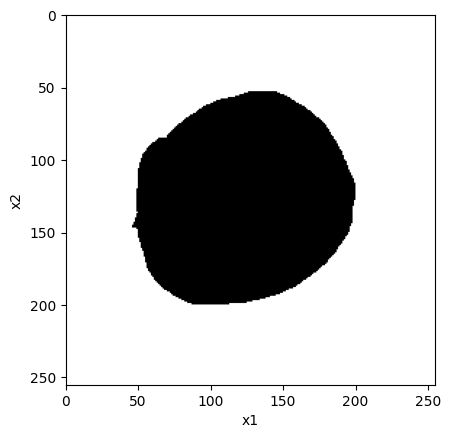

In [7]:
import matplotlib.pyplot as plt

plt.imshow(np_im_bw, cmap='binary');
plt.xlim(0,255);
plt.ylim(255,0);
plt.xlabel('x1');
plt.ylabel('x2');

## Get training, validation, and test data

In [28]:
n_train = 5000
n_val   = 1000
n_test  = 10000

X_train = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_train), np.random.randint(0, np_im_bw.shape[1], size=n_train)))
y_train = np.rot90(np_im_bw, k=3)[X_train[:,0], X_train[:,1]]

X_train = X_train/255.0
y_train = y_train/255.0


X_val = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_val), np.random.randint(0, np_im_bw.shape[1], size=n_val)))
y_val = np.rot90(np_im_bw, k=3)[X_val[:,0], X_val[:,1]]

X_val = X_val/255.0
y_val = y_val/255.0


X_test = np.column_stack((np.random.randint(0, np_im_bw.shape[0], size=n_test), np.random.randint(0, np_im_bw.shape[1], size=n_test)))
y_test = np.rot90(np_im_bw, k=3)[X_test[:,0], X_test[:,1]]

X_test = X_test/255.0
y_test = y_test/255.0

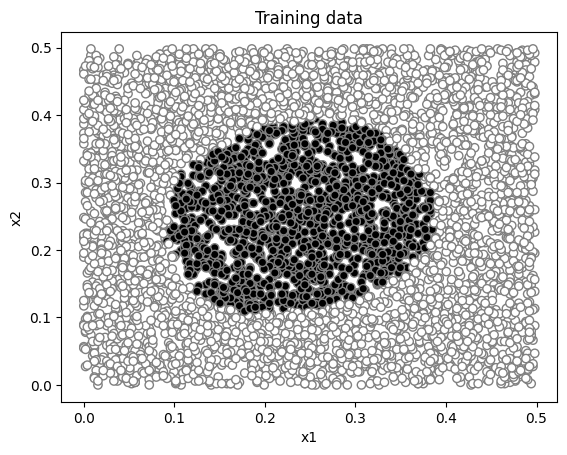

In [29]:
import seaborn as sns

plt.scatter(x=X_train[:,0], y=X_train[:,1], c=y_train, cmap='binary', edgecolors= "gray")
plt.xlabel("x1");
plt.ylabel("x2");
plt.title("Training data");

## Import Tensorflow + Keras

For this demo, we will use Tensorflow with Keras to train and configure a neural network.

Tensorflow is a powerful and widely-used platform for deep learning. However, Tensorflow is relatively low level and may be somewhat difficult to use as a starting point. We will use the `keras` package which acts as a high-level wrapper on top of tensorflow that allows you to quickly build and fit models.

(A very popular alternative to Tensorflow for working with neural networks is PyTorch - you can read more about PyTorch [here](https://pytorch.org/).)

First we import Tensorflow.

In [10]:
import tensorflow as tf
print(tf.__version__)

2.17.1


(There are two major versions of Tensorflow. Code that was written for TF1 often will not run with TF2. The current version is TF2.)

## Create the neural network

We will see if we can build a simple neural network classifier to learn the decision region that we drew above.

We first import some key sub-packages from `keras`.

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Input

Keras keeps track of computational graphs behind the scenes, and sometimes (e.g. you run this notebook several times) it may be holding on to computational graphs for models that are no longer in scope (e.g. you no longer have a variable pointing to that model). The following command frees up memory for those models, just in case.

In [12]:
import tensorflow.keras.backend as K
K.clear_session()

Now we create a very simple network.

The neural network has `nin=2` input units, corresponding to the two features.

It has one hidden layer with `nh=4` hidden units. Each hidden unit will use a sigmoid activation function.

There is `nout=1` output unit corresponding to the estimated class label. This unit will also have a sigmoid activation function.

<small>Reference: [TF+keras activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations).</small>

All of the layers are *dense* or *fully connected* layers, meaning that each node has a link to every node in the adjacent layers.

<small>Reference: [Keras layers](https://keras.io/api/layers/)</small>

In [14]:
nin = 2  # dimension of input data
nh = 4  # number of hidden units
nout = 1  # number of outputs = 1 since this is binary
model = Sequential()
model.add(Input(shape=(nin,)))
model.add(Dense(units=nh, activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

(Note: a previous version of this notebook specified the input shape in the first hidden layer, instead of having a separate `Input`, but this practice is no longer recommended.)

In our visualization of the network architechture, we will also add a *bias node* at each layer. This simplifies the computation of weights by adding an extra input whose value is always 1. The bias term then comes from the weight applied to that input.

In [ ]:
#@title Visualize the network architecture

import networkx as nx

inputLayerSize  = nin
outputLayerSize = nout
hiddenLayerSize = nh


nodePos = {}
G=nx.Graph()
graphHeight = max(inputLayerSize, outputLayerSize, hiddenLayerSize)

# create nodes and note their positions
for n in range(inputLayerSize):
  nodePos['x'+str(n+1)]=(1, n)
  G.add_node('x'+str(n+1))
for n in range(outputLayerSize):
  nodePos['o'+str(n+1)]=(5, n)
  G.add_node('o'+str(n+1))
for n in range(hiddenLayerSize):
  nodePos['h'+str(n+1)]=(3, n)
  G.add_node('h'+str(n+1))

# add edges
for n in range(hiddenLayerSize):
  for m in range(inputLayerSize):
    G.add_edge('x' + str(m+1), 'h' + str(n+1))
  for m in range(outputLayerSize):
    G.add_edge('h' + str(n+1), 'o' + str(m+1))

# add bias nodes

nodePos['xb']=(1, inputLayerSize)
G.add_node('xb')
for n in range(hiddenLayerSize):
  G.add_edge('xb', 'h' + str(n+1))

nodePos['hb']=(3, hiddenLayerSize)
G.add_node('hb')
for n in range(outputLayerSize):
  G.add_edge('hb', 'o' + str(n+1))

nx.draw_networkx(G, pos=nodePos,
              node_size=1000, node_color='pink')
plt.axis('off');
plt.margins(0.2, 0.2);

Each node in the neural network applies its activation function to the weighted sum of its inputs, then passes that as output to the nodes in the next layer.

The neural network needs to learn a weight for each link in the image above (including the weights for the bias nodes).

Keras has a nice command for summarizing the network architecture:

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden (Dense)                       │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

Next, we have to select an optimizer and a loss function.

Since this is a binary classification problem, we select the `binary_crossentropy` loss.

We will also choose an optimizer (Adam) and a learning rate of `learning_rate=0.01`.

We also set the `metrics` that we wish to track during the optimization. In this case, we select `accuracy` on the training set.

Finally, before training, we must `compile` the model.

<small>Reference: [TF+keras loss functions](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [Keras optimizers](https://keras.io/api/optimizers/)</small>

In [26]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the neural network

Keras provides a simple method `fit` to run the optimization. You simply specify the number of epochs and the batch size.

We will also pass it some `validation_data` - it will also compute the loss and accuracy on the validation data at each epoch.

(During one epoch, we run as many iterations of mini-batch stochastic gradient descent as it takes to sample all the training data, without replacement.)

In [30]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=24, validation_data=(X_val,y_val))

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6257 - loss: 1.3765 - val_accuracy: 0.7020 - val_loss: 0.3559
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7107 - loss: 0.3445 - val_accuracy: 0.7270 - val_loss: 0.3241
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7155 - loss: 0.3307 - val_accuracy: 0.7270 - val_loss: 0.3208
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7347 - loss: 0.3169 - val_accuracy: 0.7270 - val_loss: 0.3168
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7156 - loss: 0.3220 - val_accuracy: 0.7270 - val_loss: 0.3097
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7199 - loss: 0.3130 - val_accuracy: 0.7270 - val_loss: 0.2965
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7083 - loss: 0.3088 - val_accuracy: 0.7270 - val_loss: 0.2774
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7270 - loss: 0.2754 - val_accu

If you run the `fit` cell more than once, it will update the fit by running more gradient descent iterations - it won’t start again from the beginning. However, it *will* overwrite your previous model “history” (i.e. the loss and accuracy per epoch from the last call to `fit`).

## Visualize output of network

To see the classification rule our neural network learned, we can plot the predicted class probability over the input space.

We can also plot the response in the each of the hidden units.

Each of the hidden units produces one linear decision region. The final nonlinear region is then formed by taking a weighted combination of these regions.

In [ ]:
#@title Visualize output of each unit

# Prepare coordinate grid
n_plot = 256
xx1, xx2 = np.meshgrid(np.arange(0, n_plot, 1),np.arange(0, n_plot, 1))
X_grid = np.hstack((xx1.reshape(n_plot**2,1), xx2.reshape(n_plot**2,1)))
X_grid = X_grid/(n_plot-1.0)

# Get the response in the hidden units
layer_hid = model.get_layer('hidden')
model1 = Model(inputs=model.get_layer(index=0).input,
               outputs=layer_hid.output)
zhid_plot = model1.predict(X_grid)
zhid_plot = zhid_plot.reshape((n_plot,n_plot,nh))

# Get the weights in the output layer
layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()

# Get the response in the output layer
yplot = model.predict(X_grid)
yplot_mat = yplot[:,0].reshape((n_plot, n_plot))

# Plot the output layer
fig = plt.figure(figsize=(15, 6))
plt.subplot(1,nh+1,1)
plt.imshow(np.flipud((yplot_mat.reshape(n_plot, n_plot))), cmap='binary');
plt.xlim(0, n_plot);
plt.ylim(n_plot,0);
plt.xticks([]);
plt.yticks([]);
plt.title("Output")
plt.xlim(0,n_plot);
plt.ylim(n_plot, 0);

# Plot the hidden layers
for i in range(nh):

    plt.subplot(1,nh+1,i+1+1)
    zhid_ploti = (zhid_plot[:,:,i])
    im = plt.imshow(zhid_ploti, vmin=0, vmax=1, cmap='binary')
    im = plt.imshow(np.flipud((zhid_ploti)), cmap='binary');
    plt.xticks([])
    plt.yticks([])
    plt.title('h{0:d}, Wo={1:4.2f}'.format(i+1,Wo[i,0]))
    plt.xlim(0,n_plot);
    plt.ylim(n_plot,0);

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.30, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax);

We can also check all of the parameters learned by the network:

In [18]:
layer_hid = model.get_layer('hidden')
Wh, bh = layer_hid.get_weights()
print('Wh=')
print(Wh)
print('bh=')
print(bh)

layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()
print('Wo=')
print(Wo)
print('bo=')
print(bo)

Wh=
[[  7.187078    2.569278    7.9348726 -11.465135 ]
 [  5.600341   10.951426  -11.355097   -1.3019073]]
bh=
[-9.415751  -8.747637  -0.8260672  3.799521 ]
Wo=
[[-12.050338]
 [-16.550558]
 [-21.721394]
 [-21.607857]]
bo=
[16.084328]


And, we can visualize the training progress vs. epoch:

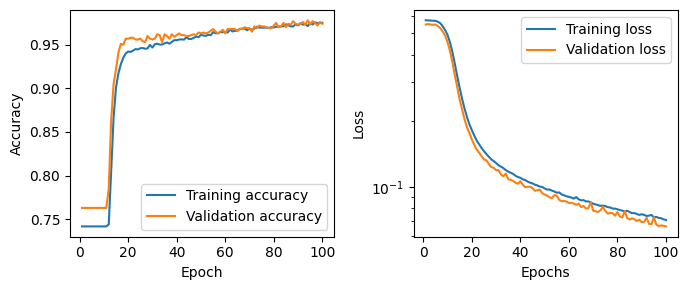

In [20]:
import seaborn as sns

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
train_acc = hist.history['accuracy'];
val_acc = hist.history['val_accuracy'];

nepochs = len(train_acc);
sns.lineplot(x=np.arange(1,nepochs+1), y=train_acc, label='Training accuracy');
sns.lineplot(x=np.arange(1,nepochs+1), y=val_acc, label='Validation accuracy');
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(1,2,2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
sns.lineplot(x=np.arange(1,nepochs+1), y=train_loss, label='Training loss');
sns.lineplot(x=np.arange(1,nepochs+1), y=val_loss, label='Validation loss');
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()

## Measure performance on test set

In [21]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_pred = y_pred.squeeze()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [22]:
np.mean((y_pred == y_test).astype(int))

0.975

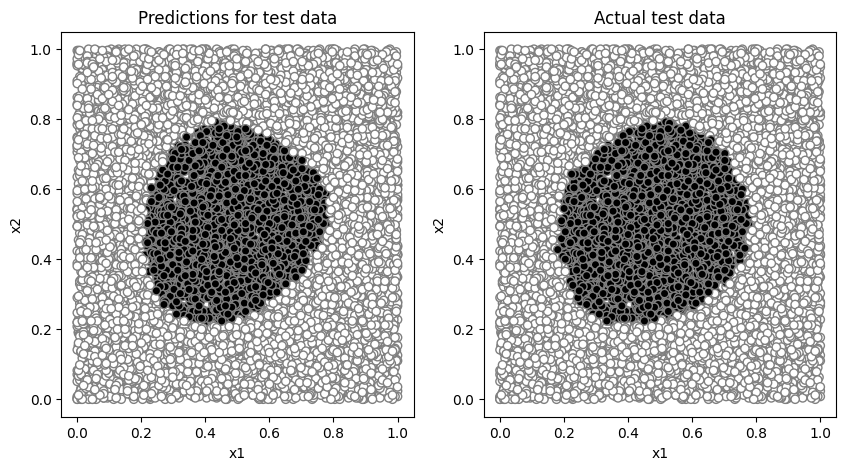

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x=X_test[:,0], y=X_test[:,1], c=y_pred, cmap='binary', edgecolors= "gray")
plt.xlabel("x1");
plt.ylabel("x2");
plt.title("Predictions for test data");

plt.subplot(1,2,2)
plt.scatter(x=X_test[:,0], y=X_test[:,1], c=y_test, cmap='binary', edgecolors= "gray")
plt.xlabel("x1");
plt.ylabel("x2");
plt.title("Actual test data");

## Things to try

-   What happens if we use `linear` activations, instead of sigmoid?
-   When do we need to use a large number of hidden units?
-   Try to adjust the learning rate and batch size. What is the effect?
-   What should you do if you want to train the model for a few more epochs? (What happens to your history when you do that?)
-   What should you do if you want to change the model architecture and train it from scratch?